In [1]:
import os
import sys 
import numpy as np
import torch as th
from matplotlib import pyplot as plt
from model import *
from aigle import aigle0D
from utility import read_out_smooth
import logging 

################## system parameters  ##################
temp = 300
md_dt=0.002
stride = 5 
smooth = 40
le_dt = md_dt * stride ## the time step of the data

print('Molecular dynamics data are collected at T={}K with time step {}ps'.format(temp, md_dt))
print('The CV trajectory will be smoothed with a Gaussian kernel and further coarse-grained to a time step of {}ps'.format(
    le_dt))
################## network parameters ##################
dev = 'cuda' if th.cuda.is_available() else 'cpu'
th.set_default_tensor_type(th.FloatTensor)
len_ag = 40 
lmem = 200

print('Time cutoff for memory kernel is {}ps'.format(lmem*le_dt))
print('Time cutoff for noise generator is {}ps'.format(len_ag*le_dt))

##################  LOADING CV Trajectory##################
elist = np.load('data/e_final.npy')
datasets_all = []
with open('./data/cv_final.npy', 'rb') as f:
    for idx, efield in enumerate(elist):
        datasets_all.append(np.load(f,allow_pickle=True))
nset  = len(datasets_all)

print('Loaded {} CV trajectories obtained under different external electric field'.format(nset))


Molecular dynamics data are collected at T=300K with time step 0.002ps
The CV trajectory will be smoothed with a Gaussian kernel and further coarse-grained to a time step of 0.01ps
Time cutoff for memory kernel is 2.0ps
Time cutoff for noise generator is 0.4ps
Loaded 60 CV trajectories obtained under different external electric field


## Training memory kernel and noise generator with CV trajectories obtained from equlibrium MD simulation under $E=2mV/A$

### train

In [2]:
################## dataset parameters ##################
relax_t = 5 ## the equlibration trajectory to be removed from training data
throw = int(relax_t / md_dt)
E = 2
################## Training parameters ##################
model_folder = 'E{}g{}s{}ag{}lmem{}'.format(E, stride, smooth, len_ag, lmem )
batchsize = 4
nepoch = 10000

## extract trainset 
trainset = []
for efield, data in zip(elist, datasets_all):
    if np.abs(efield - E) < 0.01:
        r,v,a = read_out_smooth(data, stride=stride, le_dt=le_dt, smooth = smooth, throw=throw)  # (1,steps  )
        r, v, a = r[0], v[0], a[0]   # 1D vector
        trainset.append(
            {'r':r, 'v':v, 'a':a, 'e': np.zeros_like(r)+efield,}
            )
print( ' # MD trajectories= {:d} ; # Trainset = {:d}'.format(nset, len(trainset)))
## train AIGLE
model_ext = force_model( out_channels=lmem ).to(dev)
model_noise = GAR_model( len_ag).to(dev)
if os.path.exists(model_folder) is False:
    os.mkdir(model_folder)
aigle_0d = aigle0D( temp, dt=le_dt, len_ag=len_ag, lmem=lmem, model_ext = model_ext, model_noise = model_noise  )
print('Training univariant AIGLE, output folder:{}. Details will be written to Tensorboard'.format(model_folder))
aigle_0d.train_init(  trainset, batchsize=batchsize, epoch=nepoch , model_folder=model_folder )

 # MD trajectories= 60 ; # Trainset = 4
Training univariant AIGLE, output folder:E2g5s40ag40lmem200. Details will be written to Tensorboard
iter=1000, model saved to E2g5s40ag40lmem200
iter=2000, model saved to E2g5s40ag40lmem200
iter=3000, model saved to E2g5s40ag40lmem200
iter=4000, model saved to E2g5s40ag40lmem200
iter=5000, model saved to E2g5s40ag40lmem200
iter=6000, model saved to E2g5s40ag40lmem200
iter=7000, model saved to E2g5s40ag40lmem200
iter=8000, model saved to E2g5s40ag40lmem200
iter=9000, model saved to E2g5s40ag40lmem200


### visualize memeory kernel and free energy surface

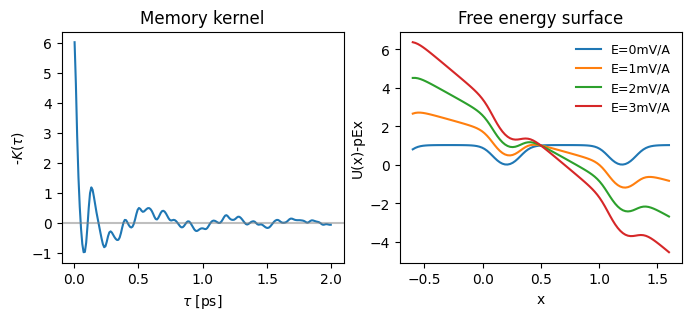

In [3]:
model_ext = aigle_0d.model_ext
lmem = aigle_0d.lmem
dt = aigle_0d.dt
fig, ax= plt.subplots(1,2,figsize=(8,3))
with th.no_grad():
    ## plot memory kernel
    ktime = (np.arange(lmem)+0.5) * dt
    ax[0].plot(ktime, -model_ext.kernel)
    ax[0].axhline(y=0, xmin=0, xmax=lmem*dt, markersize=0, alpha=0.5,color='grey')
    ax[0].set_ylabel(r'-$K(\tau)$')
    ax[0].set_xlabel(r'$\tau$ [ps]')
    ax[0].set_title('Memory kernel')
    
    ## plot free energy surface
    input_r = th.linspace(-0.6,1.6,101).to(dev)
    potential = model_ext.get_potential(input_r) 
    potential = potential - potential.min()
    for e in [0,1,2,3]:
        external_field = model_ext.get_external_force(input_r, e).flatten()
        pot = potential.flatten() -  external_field * input_r 
        pot = pot - pot[pot.shape[0]//2] + (potential.max() - potential.min())
        ax[1].plot( input_r.cpu().numpy(), pot.flatten().cpu().numpy(), label='E={}mV/A'.format(e) )
    ax[1].set_title('Free energy surface')
    ax[1].set_ylabel('U(x)-pEx')
    ax[1].set_xlabel('x')
        
    ax[1].legend(fontsize=9, frameon=False)

### validation

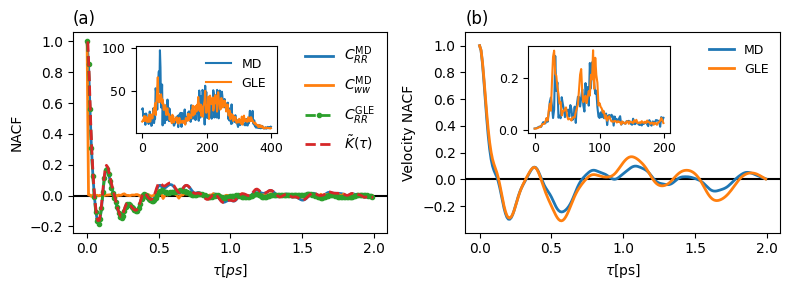

In [4]:
from utility import Corr_t
nbatch = 10
total_time = 100
label = '9000'
dt = aigle_0d.dt
################## LOAD DATA  ###########################
nset =  len(trainset) 
corr_ww = 0
corr_nn = 0
corr_vv = 0
nM = int(20 / aigle_0d.dt)
for setidx in range(nset):
    dataset= {
        'v':   th.tensor(trainset[setidx]['v'][lmem:], dtype=th.float32, device=dev),
        'r':   th.tensor(trainset[setidx]['r'][lmem:], dtype=th.float32, device=dev),
        'a':   th.tensor(trainset[setidx]['a'][lmem:], dtype=th.float32, device=dev),
        'e':   th.tensor(trainset[setidx]['e'][lmem:], dtype=th.float32, device=dev),
        'v_more': th.tensor(trainset[setidx]['v'][1:], dtype=th.float32, device=dev),
    }
    potential_force, damp_force  = aigle_0d.model_ext( dataset['r'],  dataset['v_more'], dataset['e'] )
    potential_force = potential_force.detach() 
    damp_force = damp_force.detach()
    a_pred =  potential_force + damp_force
    a_ref = dataset['a']
    noise = a_ref - a_pred
    with th.no_grad():
        noise_pred, noise_ref, noise_sigma = aigle_0d.get_noise( noise.detach() )  ##  (nx, ny, nframes-lmem)
        white_noise = noise_ref - noise_pred
    ################## Reference correlation  ###########################
    corr_ww += Corr_t( white_noise, white_noise, nM) / nset           ## Corr[ w(0), w(t)] 
    corr_nn += Corr_t( noise, noise, nM) / nset                       ## Corr[ n(0), n(t)]
    corr_vv += Corr_t( dataset['v'], dataset['v'], nM) / nset     
    
######################  SIMULATE AIGLE #########################
relax_steps = max(aigle_0d.lmem+1, aigle_0d.len_ag+1)
r_list = [dataset['r'][[i]].repeat(nbatch) for i in range(relax_steps) ]
v_list = [dataset['v'][[i]].repeat(nbatch) for i in range(relax_steps) ]
n_list = [noise[[i]].repeat(nbatch) for i in range(relax_steps)]
efield = dataset['e'][0] * 1.0
total_steps = int(total_time / dt)
aigle_0d.sim_init(r_list, v_list, n_list)
for step in range(total_steps - relax_steps):
    aigle_0d.sim_step(efield, pop=False)
    # if step % 1000 == 0:
    #     print('step:{}'.format(step))
######################  Calculate correlation #########################
aigle_0d.r_list = th.cat([ x.unsqueeze(-1) for x in aigle_0d.r_list], -1)   #( nbatch, nframes)
aigle_0d.v_list = th.cat([ x.unsqueeze(-1) for x in aigle_0d.v_list], -1)
aigle_0d.n_list = th.cat([ x.unsqueeze(-1) for x in aigle_0d.n_list], -1)
corr_nn_sim = Corr_t( aigle_0d.n_list, aigle_0d.n_list, nM)  
corr_vv_sim = Corr_t( aigle_0d.v_list, aigle_0d.v_list, nM)

######################  Plot color/white noise correlation  ########################
plot_auto = int(2/aigle_0d.dt)
fig, ax = plt.subplots(1,2, figsize=(8,3))
kernel = aigle_0d.model_ext.kernel
ax[0].axhline(y=0, color='black', markersize=0)
ax[0].plot(np.arange( plot_auto )*dt, corr_nn[:plot_auto] / corr_nn[0], 
    label=r'$C^{\mathrm{MD}}_{RR}$', markersize = 0, linewidth=2)
ax[0].plot(np.arange( plot_auto )*dt, corr_ww[:plot_auto] / corr_ww[0], 
    label=r'$C^{\mathrm{MD}}_{ww}$', markersize = 0, linewidth=2)
ax[0].plot(np.arange( plot_auto )*dt, corr_nn_sim[:plot_auto] / corr_nn_sim[0], 
    label=r'$C^{\mathrm{GLE}}_{RR}$', markersize = 3, marker='o', linestyle='dashed', linewidth=2)
ax[0].plot(np.arange( kernel.size)*dt + 0.5*dt,  kernel / kernel[0], 
    label=r'$\tilde{K}(\tau)$', markersize = 0, linestyle='dashed', linewidth=2)
ax[0].set_xlabel(r'$\tau [ps]$')
ax[0].set_ylabel('NACF')
ax[0].legend(framealpha=0, fontsize=10)
ax[0].set_title('(a)',loc='left')
## inset
ins = ax[0].inset_axes([0.2, 0.5, 0.45, 0.43] )
ins.tick_params(axis='both', which='major', labelsize=9)
## inset, Fourier corr(n,n) from data
corr_nn_fft_data =  np.fft.fft(corr_nn).real 
nframes = corr_nn_fft_data.size
x_fourier = np.arange(nframes) * 2 * np.pi / nframes / dt  
wavenumber = x_fourier / 6 / np.pi * 100
ins.plot(wavenumber[wavenumber < 400], corr_nn_fft_data[wavenumber < 400], 
        markersize=0, linestyle='solid', linewidth=1.5, label='MD' )
## inset, Fourier corr(n,n) from AIGLE
corr_nn_fft =  np.fft.fft(corr_nn_sim).real 
nframes = corr_nn_fft.size
x_fourier = np.arange(nframes) * 2 * np.pi / nframes / dt  
wavenumber = x_fourier / 6 / np.pi * 100
ins.plot(wavenumber[wavenumber < 400], corr_nn_fft[wavenumber < 400], 
        markersize=0, linestyle='solid', linewidth=1.5, label='GLE' )
ins.legend(framealpha=0, fontsize=9,)

###### plot velocity autocorrelation
plot_auto = int(2/dt)
ax[1].axhline(y=0, color='black', markersize=0)
ax[1].plot(np.arange( plot_auto )*dt, corr_vv[:plot_auto] / corr_vv[0], 
    label='MD', markersize = 0, linewidth=2)
ax[1].plot(np.arange( plot_auto )*dt, corr_vv_sim[:plot_auto] / corr_vv_sim[0], 
    label='GLE', markersize = 0, linewidth=2)
ax[1].set_xlabel(r'$\tau$[ps]')
ax[1].set_ylabel('Velocity NACF')
ax[1].set_yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0])
ax[1].legend(framealpha=0, fontsize=9,loc='upper right' )
ax[1].set_ylim(-0.4, 1.1)
ax[1].set_title('(b)',loc='left')
###### inset 
ins = ax[1].inset_axes([0.2, 0.5, 0.45, 0.43] )
ins.tick_params(axis='both', which='major', labelsize=9)
###### inset: Fourier corr(v,v) from data
corr_vv_fft_data =  np.fft.fft(corr_vv).real 
nframes = corr_vv_fft_data.size
x_fourier = np.arange(nframes) * 2 * np.pi / nframes / dt  
wavenumber = x_fourier / 6 / np.pi * 100
ins.plot(wavenumber[wavenumber < 200], corr_vv_fft_data[wavenumber < 200], 
markersize=0, linestyle='solid', linewidth=1.5,  )
###### inset: Fourier corr(v,v) from AIGLE
corr_vv_fft =  np.fft.fft(corr_vv_sim).real 
nframes = corr_vv_fft.size
x_fourier = np.arange(nframes) * 2 * np.pi / nframes / dt  
wavenumber = x_fourier / 6 / np.pi * 100
ins.plot(wavenumber[wavenumber < 200], corr_vv_fft[wavenumber < 200], 
        markersize=0, linestyle='solid', linewidth=1.5,  )
plt.tight_layout()

# Retrain free energy surface with CV trajectories obtained from non-equlibrium MD simulation

In [5]:
out_folder = model_folder + '_noneq'
batchsize = 4
nepoch = 10000

## extract train set
trainset = []
for efield, data in zip(elist, datasets_all):
    if  (efield <= 2.4 and efield >=2.0):
        r,v,a = read_out_smooth(data, stride=stride, le_dt=le_dt, smooth = smooth, throw=throw)  # (1,steps  )
        r, v, a = r[0], v[0], a[0]
        trainset.append(
            {'r':r, 'v':v, 'a':a, 'e': np.zeros_like(r)+efield,}
            )
        
## retrain free energy surface
model_ext = force_model( out_channels=lmem ).to(dev)
model_noise = GAR_model( len_ag).to(dev)
if os.path.exists(out_folder) is False:
    os.mkdir(out_folder)
aigle_0d = aigle0D( temp, dt=le_dt, len_ag=len_ag, lmem=lmem, model_ext = model_ext, model_noise = model_noise  )
aigle_0d.load_model(model_folder, label='5000')
## fix barrier height to metadynamics result
aigle_0d.model_ext.well_coef.data = aigle_0d.model_ext.well_coef.data*0 + 0.55
aigle_0d.model_ext.well_coef.requires_grad = False
aigle_0d.train_force( trainset, batchsize=batchsize,  epoch=nepoch , model_folder=out_folder )


iter=1000, model saved to E2g5s40ag40lmem200_noneq
iter=2000, model saved to E2g5s40ag40lmem200_noneq
iter=3000, model saved to E2g5s40ag40lmem200_noneq
iter=4000, model saved to E2g5s40ag40lmem200_noneq
iter=5000, model saved to E2g5s40ag40lmem200_noneq
iter=6000, model saved to E2g5s40ag40lmem200_noneq
iter=7000, model saved to E2g5s40ag40lmem200_noneq
iter=8000, model saved to E2g5s40ag40lmem200_noneq
iter=9000, model saved to E2g5s40ag40lmem200_noneq


### visualize memeory kernel and free energy surface

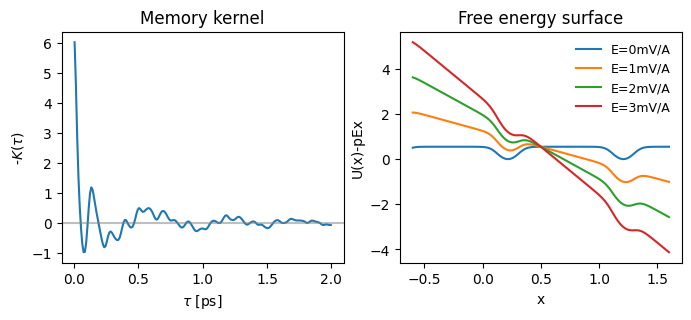

In [6]:
model_ext = aigle_0d.model_ext
lmem = aigle_0d.lmem
dt = aigle_0d.dt
fig, ax= plt.subplots(1,2,figsize=(8,3))
with th.no_grad():
    ## plot memory kernel
    ktime = (np.arange(lmem)+0.5) * dt
    ax[0].plot(ktime, -model_ext.kernel)
    ax[0].axhline(y=0, xmin=0, xmax=lmem*dt, markersize=0, alpha=0.5,color='grey')
    ax[0].set_ylabel(r'-$K(\tau)$')
    ax[0].set_xlabel(r'$\tau$ [ps]')
    ax[0].set_title('Memory kernel')
    
    ## plot free energy surface
    input_r = th.linspace(-0.6,1.6,101).to(dev)
    potential = model_ext.get_potential(input_r) 
    potential = potential - potential.min()
    for e in [0,1,2,3]:
        external_field = model_ext.get_external_force(input_r, e).flatten()
        pot = potential.flatten() -  external_field * input_r 
        pot = pot - pot[pot.shape[0]//2] + (potential.max() - potential.min())
        ax[1].plot( input_r.cpu().numpy(), pot.flatten().cpu().numpy(), label='E={}mV/A'.format(e) )
    ax[1].set_title('Free energy surface')
    ax[1].set_ylabel('U(x)-pEx')
    ax[1].set_xlabel('x')
        
    ax[1].legend(fontsize=9, frameon=False)